In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/task-segmentation/Task - Segmentation/images/245_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/442_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/073_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/364_2HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/137_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/094_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/001_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/034_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/213_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/291_2HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/491_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/253_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/221_HC.png
/kaggle/input/task-segmentation/Task - Segmentation/images/119_HC.png
/kaggle/input/task

In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]

        # -------- IMAGE --------
        img_path = os.path.join(self.image_dir, image_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image / 255.0

        # -------- MASK --------
        base_name = os.path.splitext(image_name)[0]
        mask_name = base_name + "_Annotation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 0).astype(np.float32)   # binary mask
        mask = np.expand_dims(mask, axis=0)

        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float)

        return image, mask


In [11]:
import os

IMAGE_DIR = "/kaggle/input/task-segmentation/Task - Segmentation/images"
MASK_DIR  = "/kaggle/input/task-segmentation/Task - Segmentation/masks"

print("Images:", len(os.listdir(IMAGE_DIR)))
print("Masks:", len(os.listdir(MASK_DIR)))


Images: 622
Masks: 623


Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


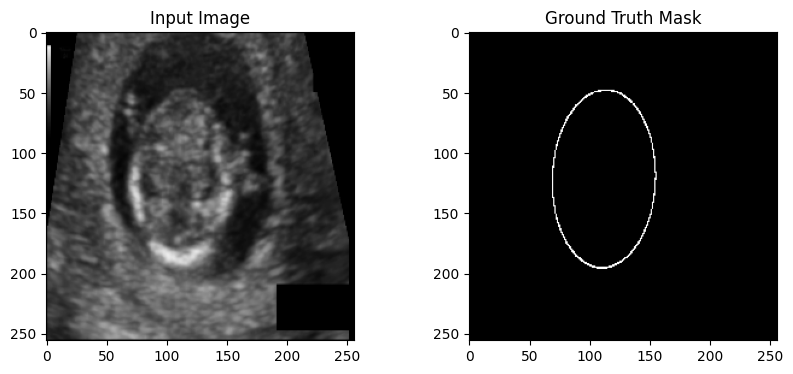

In [12]:
dataset = SegmentationDataset(IMAGE_DIR, MASK_DIR)

img, mask = dataset[10]

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")
plt.show()


In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.u1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.u2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.u3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.u4 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.c1 = DoubleConv(1024, 512)
        self.c2 = DoubleConv(512, 256)
        self.c3 = DoubleConv(256, 128)
        self.c4 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    # ✅ FORWARD MUST BE INSIDE THE CLASS
    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.pool(d1))
        d3 = self.d3(self.pool(d2))
        d4 = self.d4(self.pool(d3))

        b = self.bottleneck(self.pool(d4))

        u1 = self.u1(b)
        c1 = self.c1(torch.cat([u1, d4], dim=1))

        u2 = self.u2(c1)
        c2 = self.c2(torch.cat([u2, d3], dim=1))

        u3 = self.u3(c2)
        c3 = self.c3(torch.cat([u3, d2], dim=1))

        u4 = self.u4(c3)
        c4 = self.c4(torch.cat([u4, d1], dim=1))

        return self.out(c4)   # 🔴 NO SIGMOID


In [14]:
IMAGE_DIR = "/kaggle/input/task-segmentation/Task - Segmentation/images"
MASK_DIR  = "/kaggle/input/task-segmentation/Task - Segmentation/masks"

dataset = SegmentationDataset(IMAGE_DIR, MASK_DIR)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- MODEL ----------------
model = UNet().to(device)

# 🔥 HE INITIALIZATION (THIS WAS MISSING)
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)   # ✅ THIS LINE IS CRITICAL

# ---------------- LOSS (STAGE 1) ----------------
pos_weight = torch.tensor([50.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ---------------- OPTIMIZER ----------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



In [15]:
img, mask = next(iter(loader))
img, mask = img.to(device), mask.to(device)

optimizer.zero_grad()
logits = model(img)
loss = criterion(logits, mask)
loss.backward()

for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean().item())
        break


d1.conv.0.weight 0.026331495493650436


🔵 Stage 1: BCE-only warmup
[Stage 1 | Epoch 1/5] Loss: 0.5041
[Stage 1 | Epoch 2/5] Loss: 0.3361
[Stage 1 | Epoch 3/5] Loss: 0.2891
[Stage 1 | Epoch 4/5] Loss: 0.2626
[Stage 1 | Epoch 5/5] Loss: 0.2457

🔵 Stage 2: BCE + Dice training
[Stage 2 | Epoch 1/50] Loss: 0.9993 | Dice: 0.2545 | IoU: 0.1460
[Stage 2 | Epoch 2/50] Loss: 0.9841 | Dice: 0.2854 | IoU: 0.1666
[Stage 2 | Epoch 3/50] Loss: 0.9444 | Dice: 0.2976 | IoU: 0.1750
[Stage 2 | Epoch 4/50] Loss: 0.9123 | Dice: 0.3053 | IoU: 0.1803
[Stage 2 | Epoch 5/50] Loss: 0.8738 | Dice: 0.3664 | IoU: 0.2245


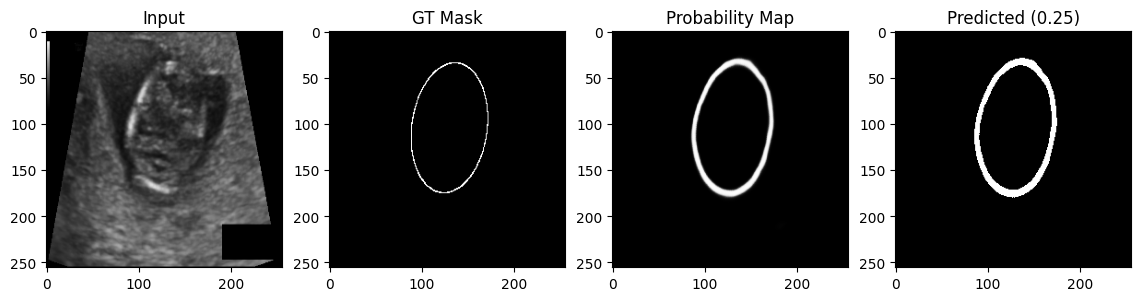

[Stage 2 | Epoch 6/50] Loss: 0.8402 | Dice: 0.3881 | IoU: 0.2410
[Stage 2 | Epoch 7/50] Loss: 0.7981 | Dice: 0.3801 | IoU: 0.2348
[Stage 2 | Epoch 8/50] Loss: 0.7547 | Dice: 0.4070 | IoU: 0.2558
[Stage 2 | Epoch 9/50] Loss: 0.7229 | Dice: 0.4549 | IoU: 0.2947
[Stage 2 | Epoch 10/50] Loss: 0.6988 | Dice: 0.4609 | IoU: 0.2998


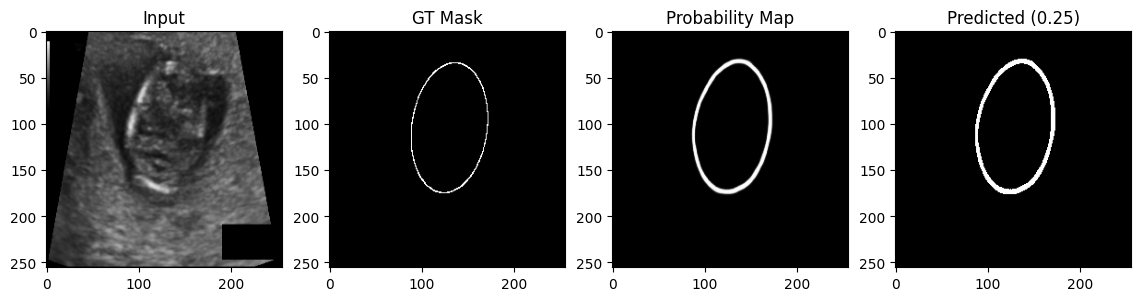

[Stage 2 | Epoch 11/50] Loss: 0.6488 | Dice: 0.4861 | IoU: 0.3214
[Stage 2 | Epoch 12/50] Loss: 0.6217 | Dice: 0.5072 | IoU: 0.3400
[Stage 2 | Epoch 13/50] Loss: 0.6102 | Dice: 0.5444 | IoU: 0.3744
[Stage 2 | Epoch 14/50] Loss: 0.5595 | Dice: 0.5663 | IoU: 0.3955
[Stage 2 | Epoch 15/50] Loss: 0.5542 | Dice: 0.5970 | IoU: 0.4260


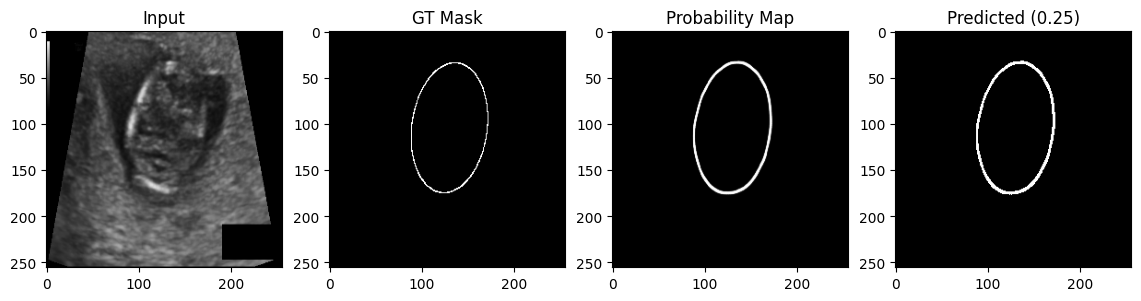

[Stage 2 | Epoch 16/50] Loss: 0.5457 | Dice: 0.5770 | IoU: 0.4060
[Stage 2 | Epoch 17/50] Loss: 0.5223 | Dice: 0.6070 | IoU: 0.4363
[Stage 2 | Epoch 18/50] Loss: 0.5061 | Dice: 0.6008 | IoU: 0.4298
[Stage 2 | Epoch 19/50] Loss: 0.4926 | Dice: 0.6252 | IoU: 0.4554
[Stage 2 | Epoch 20/50] Loss: 0.4950 | Dice: 0.6078 | IoU: 0.4371


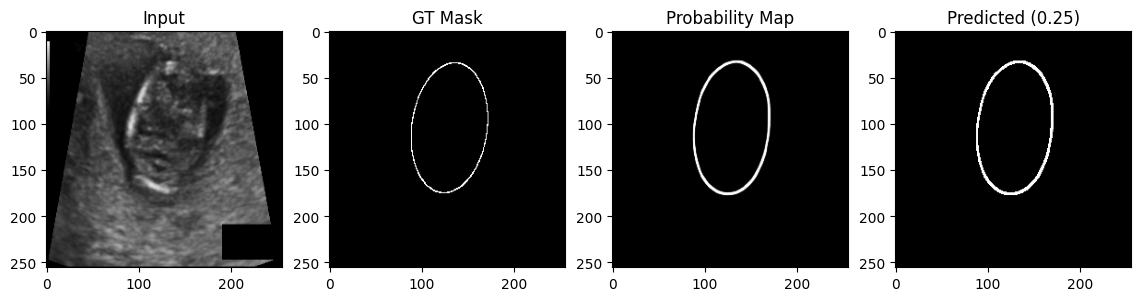

[Stage 2 | Epoch 21/50] Loss: 0.4761 | Dice: 0.6367 | IoU: 0.4680
[Stage 2 | Epoch 22/50] Loss: 0.4696 | Dice: 0.6739 | IoU: 0.5092
[Stage 2 | Epoch 23/50] Loss: 0.4653 | Dice: 0.6562 | IoU: 0.4889
[Stage 2 | Epoch 24/50] Loss: 0.4548 | Dice: 0.6775 | IoU: 0.5132
[Stage 2 | Epoch 25/50] Loss: 0.4577 | Dice: 0.6440 | IoU: 0.4755


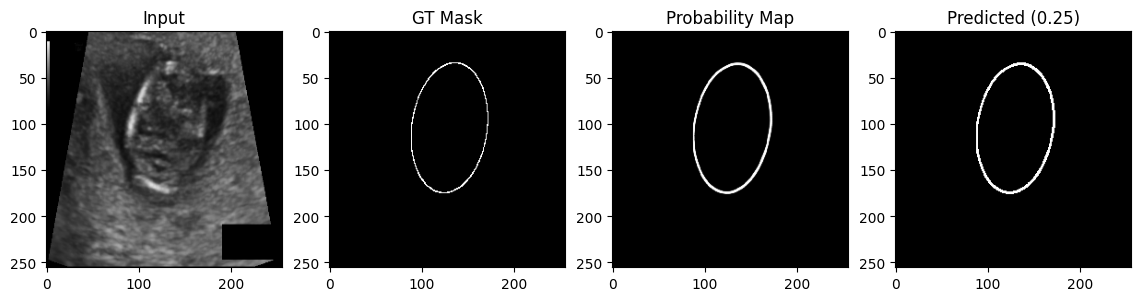

[Stage 2 | Epoch 26/50] Loss: 0.4421 | Dice: 0.6570 | IoU: 0.4897
[Stage 2 | Epoch 27/50] Loss: 0.4335 | Dice: 0.6660 | IoU: 0.4999
[Stage 2 | Epoch 28/50] Loss: 0.4253 | Dice: 0.6845 | IoU: 0.5209
[Stage 2 | Epoch 29/50] Loss: 0.4107 | Dice: 0.6953 | IoU: 0.5335
[Stage 2 | Epoch 30/50] Loss: 0.4069 | Dice: 0.6909 | IoU: 0.5283


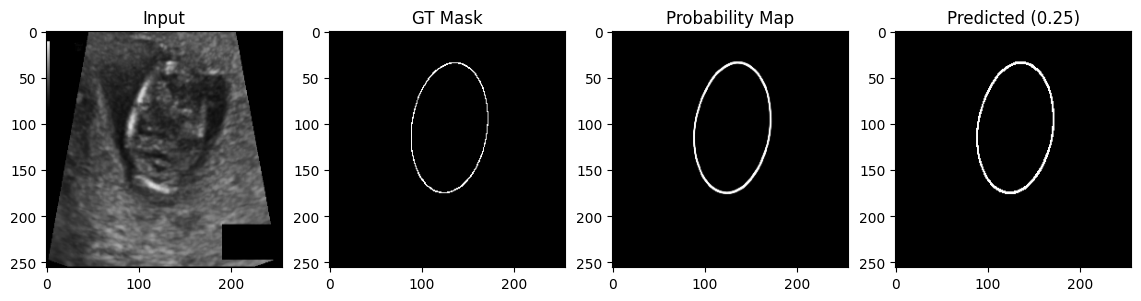

[Stage 2 | Epoch 31/50] Loss: 0.4030 | Dice: 0.6903 | IoU: 0.5277
[Stage 2 | Epoch 32/50] Loss: 0.3981 | Dice: 0.6981 | IoU: 0.5367
[Stage 2 | Epoch 33/50] Loss: 0.3903 | Dice: 0.7107 | IoU: 0.5519
[Stage 2 | Epoch 34/50] Loss: 0.3883 | Dice: 0.7130 | IoU: 0.5546
[Stage 2 | Epoch 35/50] Loss: 0.3869 | Dice: 0.7091 | IoU: 0.5499


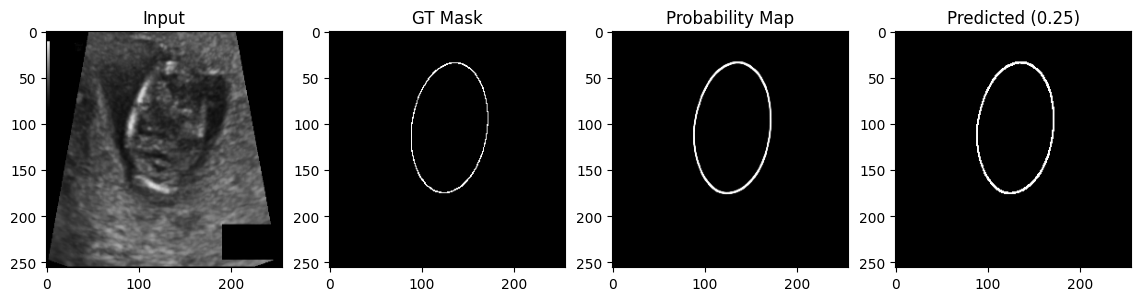

[Stage 2 | Epoch 36/50] Loss: 0.3721 | Dice: 0.7204 | IoU: 0.5638
[Stage 2 | Epoch 37/50] Loss: 0.3743 | Dice: 0.7065 | IoU: 0.5468
[Stage 2 | Epoch 38/50] Loss: 0.3612 | Dice: 0.7302 | IoU: 0.5757
[Stage 2 | Epoch 39/50] Loss: 0.3638 | Dice: 0.7415 | IoU: 0.5898
[Stage 2 | Epoch 40/50] Loss: 0.3541 | Dice: 0.7448 | IoU: 0.5940


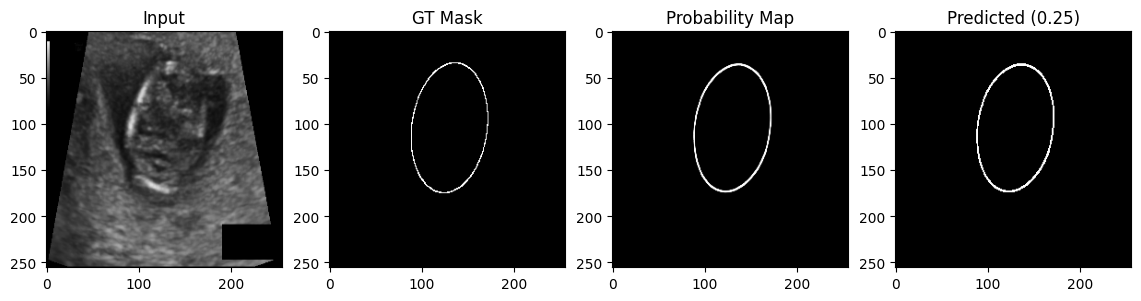

[Stage 2 | Epoch 41/50] Loss: 0.3587 | Dice: 0.7452 | IoU: 0.5945
[Stage 2 | Epoch 42/50] Loss: 0.3451 | Dice: 0.7304 | IoU: 0.5758
[Stage 2 | Epoch 43/50] Loss: 0.3528 | Dice: 0.7150 | IoU: 0.5573
[Stage 2 | Epoch 44/50] Loss: 0.3431 | Dice: 0.7472 | IoU: 0.5968
[Stage 2 | Epoch 45/50] Loss: 0.3285 | Dice: 0.7393 | IoU: 0.5872


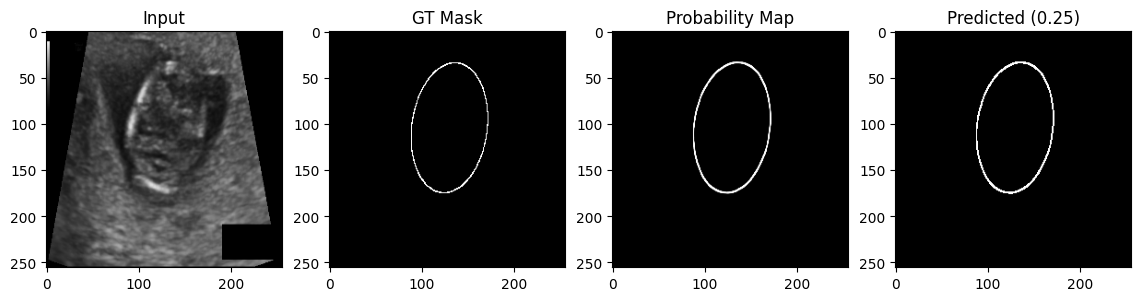

[Stage 2 | Epoch 46/50] Loss: 0.3385 | Dice: 0.7664 | IoU: 0.6219
[Stage 2 | Epoch 47/50] Loss: 0.3259 | Dice: 0.7698 | IoU: 0.6264
[Stage 2 | Epoch 48/50] Loss: 0.3308 | Dice: 0.7715 | IoU: 0.6286
[Stage 2 | Epoch 49/50] Loss: 0.3214 | Dice: 0.7719 | IoU: 0.6290
[Stage 2 | Epoch 50/50] Loss: 0.3041 | Dice: 0.7734 | IoU: 0.6309


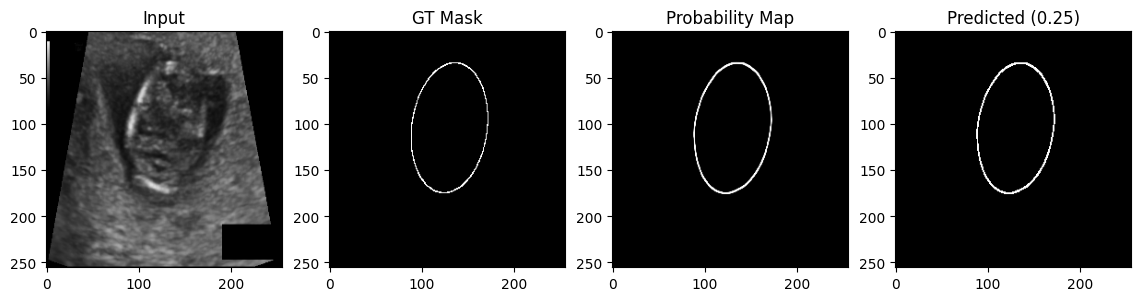

In [16]:
# =========================
# DEVICE
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# MODEL + HE INITIALIZATION
# =========================
model = UNet().to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# =========================
# OPTIMIZER
# =========================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# =========================
# LOSS FUNCTIONS
# =========================
pos_weight = torch.tensor([50.0]).to(device)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def dice_loss_logits(logits, target, smooth=1.0):
    probs = torch.sigmoid(logits)
    probs = probs.view(-1)
    target = target.view(-1)
    intersection = (probs * target).sum()
    return 1 - ((2. * intersection + smooth) /
                (probs.sum() + target.sum() + smooth))

def combined_loss(logits, target):
    return bce_loss(logits, target) + dice_loss_logits(logits, target)

# =========================
# METRICS
# =========================
def dice_coeff(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# =========================
# -------- STAGE 1 --------
# BCE ONLY (5 EPOCHS)
# =========================
print("🔵 Stage 1: BCE-only warmup")

epochs_stage1 = 5
criterion = bce_loss

for epoch in range(epochs_stage1):
    model.train()
    epoch_loss = 0

    for img, mask in loader:
        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, mask)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[Stage 1 | Epoch {epoch+1}/{epochs_stage1}] Loss: {epoch_loss/len(loader):.4f}")

# =========================
# -------- STAGE 2 --------
# BCE + DICE (UP TO 50 EPOCHS)
# =========================
print("\n🔵 Stage 2: BCE + Dice training")

epochs_stage2 = 50
criterion = combined_loss

for epoch in range(epochs_stage2):
    model.train()
    epoch_loss = 0

    for img, mask in loader:
        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, mask)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    # =========================
    # EVALUATION
    # =========================
    model.eval()
    dice_scores, iou_scores = [], []

    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            logits = model(img)
            prob = torch.sigmoid(logits)
            pred = (prob > 0.25).float()

            dice_scores.append(dice_coeff(pred, mask).item())
            iou_scores.append(iou_score(pred, mask).item())

    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)

    print(f"[Stage 2 | Epoch {epoch+1}/{epochs_stage2}] "
          f"Loss: {epoch_loss/len(loader):.4f} | "
          f"Dice: {mean_dice:.4f} | IoU: {mean_iou:.4f}")

    # =========================
    # VISUAL DEBUG EVERY 5 EPOCHS
    # =========================
    if (epoch + 1) % 5 == 0:
        img, mask = dataset[20]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img)
            prob = torch.sigmoid(logits).cpu().squeeze()

        plt.figure(figsize=(14,4))
        plt.subplot(1,4,1)
        plt.title("Input")
        plt.imshow(img.cpu().squeeze().permute(1,2,0))

        plt.subplot(1,4,2)
        plt.title("GT Mask")
        plt.imshow(mask.squeeze(), cmap="gray")

        plt.subplot(1,4,3)
        plt.title("Probability Map")
        plt.imshow(prob, cmap="gray")

        plt.subplot(1,4,4)
        plt.title("Predicted (0.25)")
        plt.imshow((prob > 0.25), cmap="gray")

        plt.show()


In [22]:
import os

os.makedirs("Model_Weights", exist_ok=True)

SAVE_PATH = "Model_Weights/hypothesis_final_full_saved_model.pth"

torch.save(model.state_dict(), SAVE_PATH)

print(f"✅ Model weights saved at: {SAVE_PATH}")


✅ Model weights saved at: Model_Weights/hypothesis_final_full_saved_model.pth
